# **ETL**

<!-- ## Objectives

* Extract London Crime statistics CSV data from ??? and from the data folder into a data frame and explore its features
* Feature engeneering of interesting metadata and KPIs

## Inputs

* MPS Ward Level Crime (most recent 24 months).csv

## Outputs

* cleaned and feture engeneered csv data file 

## Additional Comments



---

# Load Libaries and Data

We use the pandas and numpy libury for data manipulation and mathplotlib for basic visualisations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We load the csv file out of the data/raw folder into a pandas dataframe (df) and look up the shape and head 

In [2]:
df = pd.read_csv("../data/raw/MPSCrime.csv")
print(df.shape)
df.head()

(18693, 29)


,MajorText,MinorText,WardName,WardCode,LookUp_BoroughName,202311,202312,202401,202402,202403,...,202501,202502,202503,202504,202505,202506,202507,202508,202509,202510
0,ARSON AND CRIMINAL DAMAGE,ARSON,Heathrow Villages,E05013570,Aviation Security (SO18),0,1,3,0,2,...,2,1,1,0,0,5,3,2,0,0
1,ARSON AND CRIMINAL DAMAGE,CRIMINAL DAMAGE,Heathrow Villages,E05013570,Aviation Security (SO18),17,36,25,28,21,...,28,23,27,25,15,18,25,24,30,27
2,BURGLARY,BURGLARY BUSINESS AND COMMUNITY,Heathrow Villages,E05013570,Aviation Security (SO18),1,4,2,9,6,...,3,5,2,5,6,4,1,4,2,5
3,BURGLARY,RES BURGLARY OF A HOME,Heathrow Villages,E05013570,Aviation Security (SO18),7,8,11,7,3,...,5,4,10,2,1,8,1,4,2,3
4,BURGLARY,RES BURGLARY OF UNCONNECTED BUILDING,Heathrow Villages,E05013570,Aviation Security (SO18),3,3,1,0,1,...,1,0,0,1,0,1,0,2,1,0


For easyer understanding we change the Major and Minor Text to Crime Category and Specific Crime Type repectivly.

In [3]:
df = df.rename(columns={
    'MajorText': 'Crime Category',
    'MinorText': 'Specific Crime Type'
})

---

# Data Cleaning 

Checking for duplicates and missing values

In [4]:
df.isnull().sum()

Crime Category         0
Specific Crime Type    0
WardName               0
WardCode               0
LookUp_BoroughName     0
202311                 0
202312                 0
202401                 0
202402                 0
202403                 0
202404                 0
202405                 0
202406                 0
202407                 0
202408                 0
202409                 0
202410                 0
202411                 0
202412                 0
202501                 0
202502                 0
202503                 0
202504                 0
202505                 0
202506                 0
202507                 0
202508                 0
202509                 0
202510                 0
dtype: int64

In [5]:
df.duplicated().sum()

0

Seems like there is no missing values or duplicated we should take care of.

Lets see the overall types.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18693 entries, 0 to 18692
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Crime Category       18693 non-null  object
 1   Specific Crime Type  18693 non-null  object
 2   WardName             18693 non-null  object
 3   WardCode             18693 non-null  object
 4   LookUp_BoroughName   18693 non-null  object
 5   202311               18693 non-null  int64 
 6   202312               18693 non-null  int64 
 7   202401               18693 non-null  int64 
 8   202402               18693 non-null  int64 
 9   202403               18693 non-null  int64 
 10  202404               18693 non-null  int64 
 11  202405               18693 non-null  int64 
 12  202406               18693 non-null  int64 
 13  202407               18693 non-null  int64 
 14  202408               18693 non-null  int64 
 15  202409               18693 non-null  int64 
 16  2024

### Unique data categories

lets see which categories of crime there are (MajorText) and which types are part of them.


In [7]:
df['Crime Category'].unique()


array(['ARSON AND CRIMINAL DAMAGE', 'BURGLARY', 'DRUG OFFENCES',
       'MISCELLANEOUS CRIMES AGAINST SOCIETY', 'POSSESSION OF WEAPONS',
       'PUBLIC ORDER OFFENCES', 'ROBBERY', 'SEXUAL OFFENCES', 'THEFT',
       'VEHICLE OFFENCES', 'VIOLENCE AGAINST THE PERSON',
       'FRAUD AND FORGERY', 'NFIB FRAUD'], dtype=object)

In [8]:
df['Specific Crime Type'].unique()

array(['ARSON', 'CRIMINAL DAMAGE', 'BURGLARY BUSINESS AND COMMUNITY',
       'RES BURGLARY OF A HOME', 'RES BURGLARY OF UNCONNECTED BUILDING',
       'POSSESSION OF DRUGS', 'TRAFFICKING OF DRUGS',
       'MISC CRIMES AGAINST SOCIETY', 'POSSESSION OF WEAPONS',
       'OTHER OFFENCES PUBLIC ORDER', 'PUBLIC FEAR ALARM OR DISTRESS',
       'RACE OR RELIGIOUS AGG PUBLIC FEAR', 'VIOLENT DISORDER',
       'ROBBERY OF BUSINESS PROPERTY', 'ROBBERY OF PERSONAL PROPERTY',
       'OTHER SEXUAL OFFENCES', 'RAPE', 'BICYCLE THEFT', 'OTHER THEFT',
       'SHOPLIFTING', 'THEFT FROM THE PERSON',
       'AGGRAVATED VEHICLE TAKING', 'INTERFERING WITH A MOTOR VEHICLE',
       'THEFT FROM A VEHICLE', 'THEFT OR UNAUTH TAKING OF A MOTOR VEH',
       'DEATH SERIOUS INJURY ILLEGAL DRIVING', 'HOMICIDE',
       'STALKING AND HARASSMENT', 'VIOLENCE WITH INJURY',
       'VIOLENCE WITHOUT INJURY', 'FRAUD AND FORGERY',
       'BURGLARY - RESIDENTIAL', 'NFIB'], dtype=object)

Lets group them for a better overview witch crime belngs in witch categorie

In [9]:
crimes = df.groupby('Crime Category')['Specific Crime Type'].unique().reset_index()
crimes

,Crime Category,Specific Crime Type
0,ARSON AND CRIMINAL DAMAGE,"[ARSON, CRIMINAL DAMAGE]"
1,BURGLARY,"[BURGLARY BUSINESS AND COMMUNITY, RES BURGLARY..."
2,DRUG OFFENCES,"[POSSESSION OF DRUGS, TRAFFICKING OF DRUGS]"
3,FRAUD AND FORGERY,[FRAUD AND FORGERY]
4,MISCELLANEOUS CRIMES AGAINST SOCIETY,[MISC CRIMES AGAINST SOCIETY]
5,NFIB FRAUD,[NFIB]
6,POSSESSION OF WEAPONS,[POSSESSION OF WEAPONS]
7,PUBLIC ORDER OFFENCES,"[OTHER OFFENCES PUBLIC ORDER, PUBLIC FEAR ALAR..."
8,ROBBERY,"[ROBBERY OF BUSINESS PROPERTY, ROBBERY OF PERS..."
9,SEXUAL OFFENCES,"[OTHER SEXUAL OFFENCES, RAPE]"


other format:

In [10]:
df[['Crime Category', 'Specific Crime Type']].drop_duplicates().sort_values(['Crime Category', 'Specific Crime Type'])

,Crime Category,Specific Crime Type
0,ARSON AND CRIMINAL DAMAGE,ARSON
1,ARSON AND CRIMINAL DAMAGE,CRIMINAL DAMAGE
884,BURGLARY,BURGLARY - RESIDENTIAL
2,BURGLARY,BURGLARY BUSINESS AND COMMUNITY
3,BURGLARY,RES BURGLARY OF A HOME
4,BURGLARY,RES BURGLARY OF UNCONNECTED BUILDING
5,DRUG OFFENCES,POSSESSION OF DRUGS
6,DRUG OFFENCES,TRAFFICKING OF DRUGS
37,FRAUD AND FORGERY,FRAUD AND FORGERY
7,MISCELLANEOUS CRIMES AGAINST SOCIETY,MISC CRIMES AGAINST SOCIETY


Now we want to see what a crime time series would look like.
First put the colums into real time series

In [11]:
# Find all month columns
month_cols = [col for col in df.columns if col.isdigit()]

# Convert string YYYYMM → datetime
dates = pd.to_datetime(month_cols, format="%Y%m")

# Replace columns with datetime versions
df.rename(columns=dict(zip(month_cols, dates)), inplace=True)

Now we can look at the evolution of the crime categories

In [12]:
major_pivot = df.pivot_table(
    index='Crime Category',
    values=[col for col in df.columns if isinstance(col, pd.Timestamp)],
    aggfunc='sum')

major_pivot.head()


,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,...,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01,2025-08-01,2025-09-01,2025-10-01
Crime Category,,,,,,,,,,,,,,,,,,,,,
ARSON AND CRIMINAL DAMAGE,4609,4741,4820,4529,4424,4416,4560,4586,5182,4958,...,4112,4008,4476,4591,4808,4805,5214,4822,4506,4648
BURGLARY,4678,4991,5044,4385,4612,4216,4036,3878,4165,4178,...,4426,3720,3944,3595,3808,3613,3811,3972,3982,4237
DRUG OFFENCES,2867,2607,2937,2753,2578,2504,2794,2736,2907,3078,...,4080,3697,3978,4543,4897,4220,4577,4630,4291,4519
FRAUD AND FORGERY,1,0,0,1,26,23,19,17,11,6,...,4,5,4,4,2,3,1,0,0,3
MISCELLANEOUS CRIMES AGAINST SOCIETY,879,754,876,772,690,717,758,787,809,857,...,968,847,1017,1012,1043,1073,1146,1054,949,1082


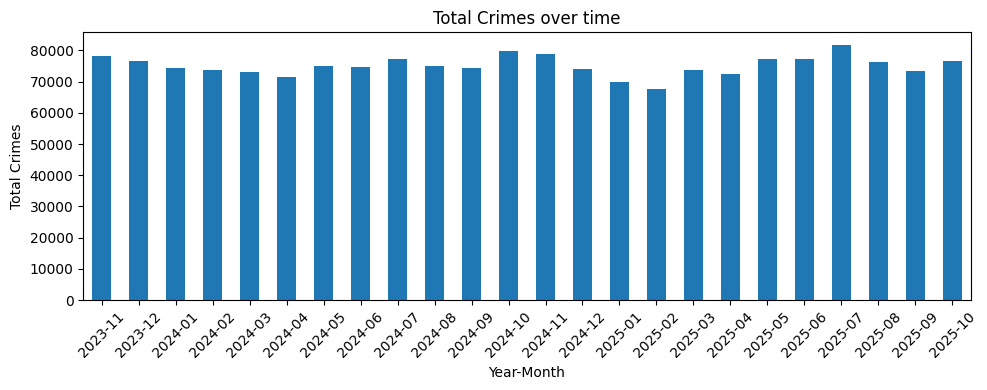

In [13]:
s = major_pivot.sum(axis=0)
plt.figure(figsize=(10, 4))
ax = s.plot(kind='bar')
ax.set_title('Total Crimes over time')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Total Crimes')
ax.set_xticklabels([dt.strftime('%Y-%m') for dt in s.index], rotation=45)
plt.tight_layout()
plt.show()

The plot indicates that total crime levels show a slight decrease during colder months. We observe seasonal patterns with crime rates typically declining in winter periods (December-February) and increasing during warmer months (June-August). This temporal pattern aligns with our hypothesis testing, which confirmed a statistically significant 6% increase in summer crime compared to winter (p=0.029).

In [14]:
# Create pivot table for specific crime types (minor categories)
minor_pivot = df.pivot_table(
    index='Specific Crime Type',
    values=[col for col in df.columns if isinstance(col, pd.Timestamp)],
    aggfunc='sum'
)

print(f"Minor pivot shape: {minor_pivot.shape}")
minor_pivot.head()

Minor pivot shape: (33, 24)


,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,...,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01,2025-08-01,2025-09-01,2025-10-01
Specific Crime Type,,,,,,,,,,,,,,,,,,,,,
AGGRAVATED VEHICLE TAKING,50,74,51,48,51,48,38,46,39,63,...,36,34,41,50,44,49,29,37,37,37
ARSON,148,159,185,152,197,198,169,182,232,317,...,179,142,178,218,194,202,192,177,137,152
BICYCLE THEFT,1168,938,964,1117,1211,1201,1394,1433,1448,1483,...,833,829,1028,1171,1354,1309,1446,1302,1313,1397
BURGLARY - RESIDENTIAL,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
BURGLARY BUSINESS AND COMMUNITY,1372,1488,1488,1422,1478,1445,1532,1464,1624,1555,...,1392,1084,1279,1285,1430,1244,1252,1268,1316,1429


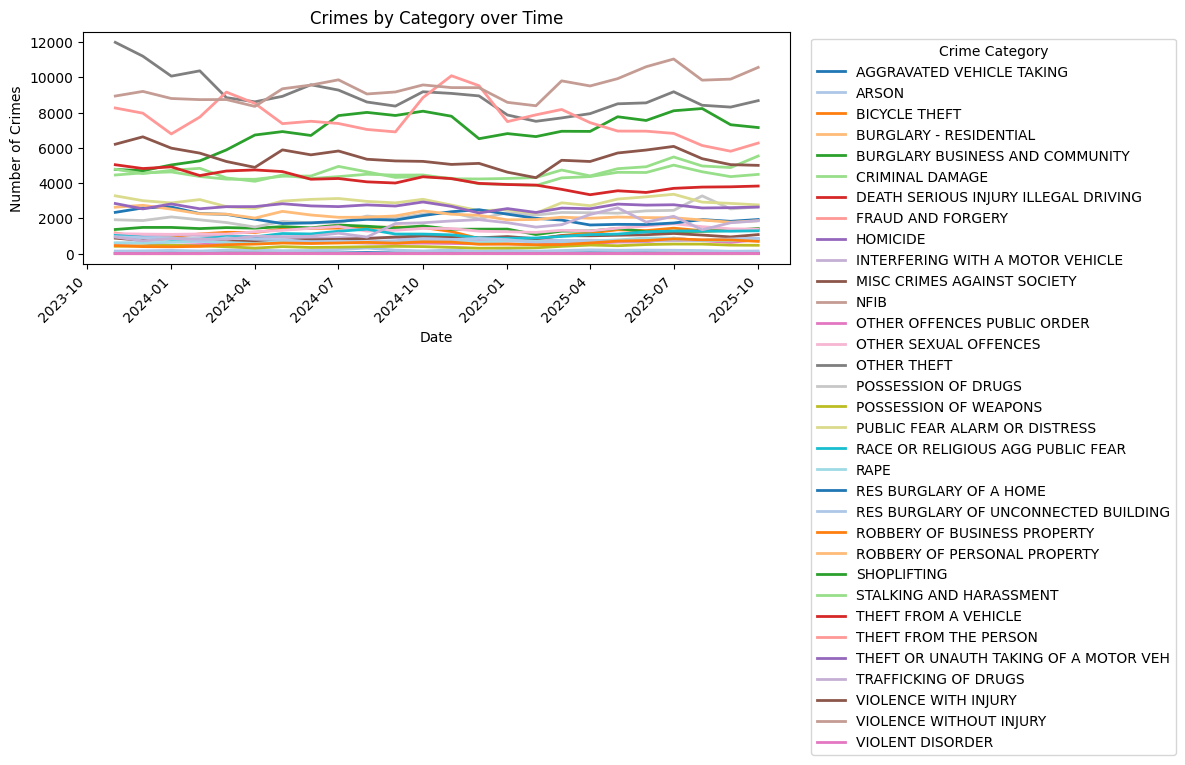

In [15]:
# use a colormap with many distinct colors (tab20) and map it to the number of series
n = minor_pivot.shape[0]
cmap = plt.get_cmap('tab20')

# get list of colors from cmap (handle both ListedColormap and continuous cmap)
base_colors = getattr(cmap, "colors", [cmap(i / max(1, n - 1)) for i in range(n)])
colors = [base_colors[i % len(base_colors)] for i in range(n)]

ax = minor_pivot.T.plot(figsize=(12, 6), linewidth=2, color=colors)
ax.set_title('Crimes by Category over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Crimes')
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Crime Category', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Crime by Location

In [16]:
loc_crime = df.groupby(['WardName', 'Crime Category'])[dates].sum().reset_index()
loc_crime.head()


,WardName,Crime Category,2023-11-01 00:00:00,2023-12-01 00:00:00,2024-01-01 00:00:00,2024-02-01 00:00:00,2024-03-01 00:00:00,2024-04-01 00:00:00,2024-05-01 00:00:00,2024-06-01 00:00:00,...,2025-01-01 00:00:00,2025-02-01 00:00:00,2025-03-01 00:00:00,2025-04-01 00:00:00,2025-05-01 00:00:00,2025-06-01 00:00:00,2025-07-01 00:00:00,2025-08-01 00:00:00,2025-09-01 00:00:00,2025-10-01 00:00:00
0,Abbey,ARSON AND CRIMINAL DAMAGE,11,8,16,9,12,13,9,9,...,11,8,8,10,12,6,15,22,11,10
1,Abbey,BURGLARY,18,3,15,7,18,10,9,5,...,11,7,6,6,6,12,9,6,8,11
2,Abbey,DRUG OFFENCES,14,7,16,7,11,5,9,11,...,9,12,15,27,18,14,9,21,11,17
3,Abbey,FRAUD AND FORGERY,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,Abbey,MISCELLANEOUS CRIMES AGAINST SOCIETY,2,4,1,0,0,3,3,1,...,2,3,1,3,1,1,3,0,1,1


In [18]:
# Save the cleaned and processed dataset
df.to_csv('../data/clean/processed_crime_data.csv', index=False)
print("✓ Processed data saved to: data/clean/processed_crime_data.csv")
print(f"✓ Shape: {df.shape}")
print(f"✓ File size: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✓ Processed data saved to: data/clean/processed_crime_data.csv
✓ Shape: (18693, 29)
✓ File size: 9.03 MB


---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---